# Machine Learning Engineer Nanodegree
## Capstone Project
## Project: Email Spam Classifier


## Overview:
Spam filtering is a binary classification task familiar to any user of email services. We will use machine learning classifiers to implement a similar spam filter.

The task is to distinguish between two types of emails, “spam” and “non-spam” often called “ham”. The machine learning classifier will detect that an email is spam if it is characterised by certain features. The features would be generated based on the textual content of the mail.

In [1]:
#Import the libraries
import os
import re
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import operator
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from time import time
from wordcloud import WordCloud

## Reading Data

Apache SpamAssasin public corpus has spam and ham mails data. 
Below is the URL of the corpus data
http://spamassassin.apache.org/old/publiccorpus/ 


While reading the email from corpus file, opening the file with utf8 encoding. If UnicodeDecodeError occurs due to not supported character, we catch the exception and continue reading next file

In [2]:
def init_lists(folder):
    a_list = []
    file_list = os.listdir(folder)
    for a_file in file_list:
        f = open(folder + a_file, 'r')
        try:
            a_list.append(f.read().encode("utf8"))
        except UnicodeDecodeError:
            #print(a_file)
            continue
    f.close()
    return a_list

Read all Spam and Ham Mails and put them in two lists: one for spam mails and other for ham mails

In [3]:
spam1MailList = init_lists('EmailSpamData/20030228_spam/spam/')
spam2MailList = init_lists('EmailSpamData/20050311_spam_2/spam_2/')

easyHam1MailList = init_lists('EmailSpamData/20030228_easy_ham/easy_ham/')
easyHam2MailList = init_lists('EmailSpamData/20030228_easy_ham_2/easy_ham_2/')
hardHamMailList = init_lists('EmailSpamData/20030228_hard_ham/hard_ham/')

spamMailList = spam1MailList + spam2MailList
hamMailList = easyHam1MailList + easyHam2MailList + hardHamMailList

## Data Preprocesser Helpers

Implementing a Data Preporcessor helper '**preprocess_normalize**' for following purpose:
    Remove htmls markups
    Normalize numbers, Urls, email address and Dollar sign
      Replace 0-9 with ‘number
      hyperlinks with 'httpaddr'
      Email address with 'emailaddr'
      $ with 'dollar' 

In [7]:
def preprocess_normalize(email):
    # replace html tag
    email = re.sub(r"<[^<>]+>", " ", email)

    # replace 0-9 with number 
    email = re.sub(r"[0-9]+", "number", email)


    # replace hyperlinks with 'httpaddr'
    email = re.sub(r"(http|https)://[^\s]*", "httpaddr", email)


    # replace any email address with 'emailaddr'
    email = re.sub(r"[^\s]+@[^\s]+", "emailaddr", email) 

    # replace $ with 'dollar'
    email = re.sub(r"[$]+", "dollar", email) 
    
    return email
    


Implementing a Data Preporcessor helper '**preprocess_lemmatize_tokenize**' for following tasks
    Tokenize the words
    Take only alphanumeric words,
    Filter stop words (words which do not have significance like : to, the, a etc
    Lemmatize and change case to lower to reduce the words to their stemmed form


In [8]:
stoplist = stopwords.words('english')

def preprocess_lemmatize_tokenize(email):
    #tokenize
    tokens = word_tokenize(email)

    #take only alphanumeric
    alphaNumericTokens =  [word for word in tokens if word.isalpha()]

    #filter stoplist words
    nonStoplistWords =  [word for word in alphaNumericTokens if not word in stoplist]

    #lemmatize and change case to lower
    lemmatizedAlphaNumericTokens = [WordNetLemmatizer().lemmatize(word.lower()) for word in nonStoplistWords]

    #filter stoplist words
    return lemmatizedAlphaNumericTokens


Implement a custom tokenizer **LemmatizerTokenizer** which will use preprocess_lemmatize_tokenize defined earlier for data preprocessing steps. This custom tokenizer class will be used in TfidfVectorizer later during feature extraction

In [9]:
class LemmatizerTokenizer(object):
        def __init__(self):
            self.wnl = WordNetLemmatizer()
        def __call__(self, doc):
            return preprocess_lemmatize_tokenize(doc)
              

## Data Exploration and  Visualization

In [15]:
print("Number of Spam mails : {}".format(len(spamMailList)))
print("Number of Ham mails : {}".format(len(hamMailList)))

print("Percentage of spam mails : {:.2f} %".format((float(len(spamMailList))/ (len(spamMailList) + len(hamMailList)))*100))

Number of Spam mails : 1692
Number of Ham mails : 3845
Percentage of spam mails : 30.56 %


In [48]:
def preprocess_visuals(email):
    # normalize
    email = preprocess_normalize(email)
    
    #lemmatize and Tockenize
    return preprocess_lemmatize_tokenize(email)

def get_wordFrequency(words):
    return {word: count for word, count in Counter(words).items()}

Processing email text to get the unique word and its occurance count in Spam and Ham mails. While processing we are using the same logic to Normalize, Tockenize and Lemmatize, which will be used during feature extraction while training the classifiers.

In [49]:
processedSpamMailList = [ preprocess_visuals(email)for email in spamMailList]
processedHamMailList = [ preprocess_visuals(email)for email in hamMailList]

spamMailWordFrequencyList = [get_wordFrequency(words) for words in processedSpamMailList]
hamMailWordFrequencyList = [get_wordFrequency(words) for words in processedHamMailList]

allSpamWordFrequency = dict(sum((Counter(x) for x in spamMailWordFrequencyList),Counter()))
allHamWordFrequency = dict(sum((Counter(x) for x in hamMailWordFrequencyList),Counter()))


In [50]:
print("Total Word Count in Spam mail Words : {}".format(len(allSpamWordFrequency)))
print("Total Word Count in Ham mails Words : {}".format(len(allHamWordFrequency)))

Total Word Count in Spam mail Words : 24475
Total Word Count in Ham mails Words : 38793


### Word Cloud Visualization
Word cloud (tag cloud, or weighted list in visual design) is a visual representation of text data. Tags are usually single words, and the importance of each tag is shown with font size or color, which gives greater prominence to words that appear more frequently. Two separate word cloud map is created for spam and ham words. This visualization makes it easier to see relative frequency of words in spam and ham mails

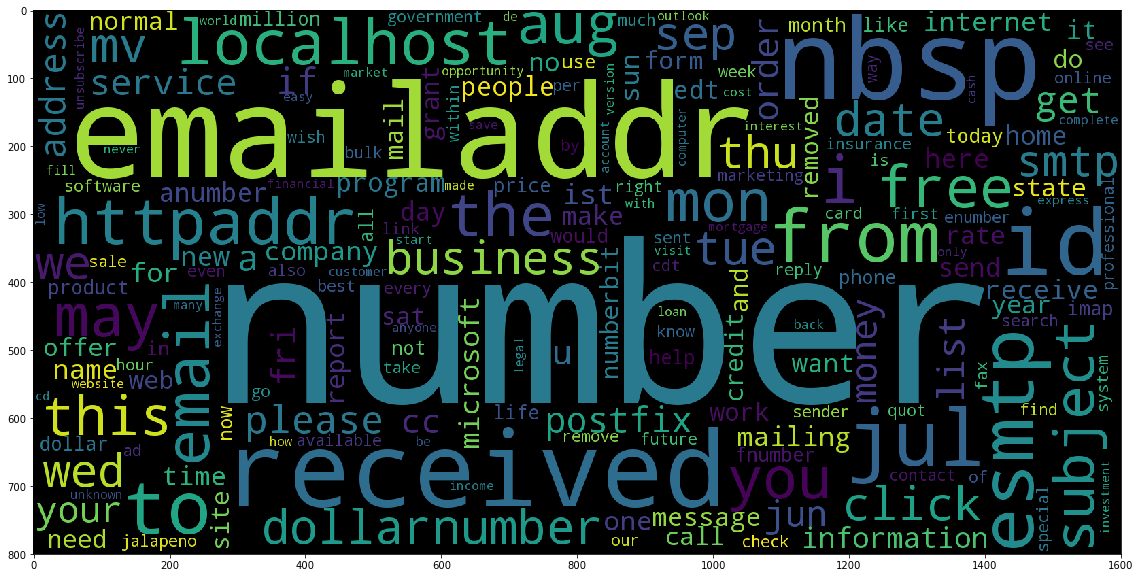

In [33]:
wcSpam = WordCloud(width=1600, height=800).generate_from_frequencies(allSpamWordFrequency)
matplotlib.pyplot.figure( figsize=(20,10) )
matplotlib.pyplot.imshow(wcSpam)
matplotlib.pyplot.show()

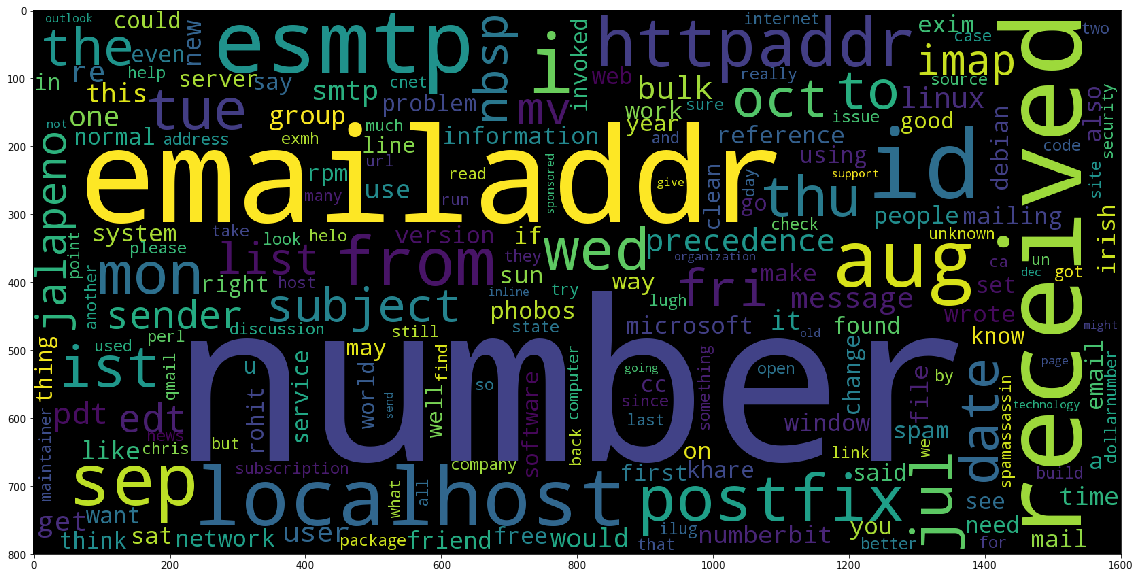

In [34]:
wcHam = WordCloud(width=1600, height=800).generate_from_frequencies(allHamWordFrequency)
matplotlib.pyplot.figure( figsize=(20,10) )
matplotlib.pyplot.imshow(wcHam)
matplotlib.pyplot.show()

### Frequency Histogram: 

100 most frequent word and its frequency is plotted for spam email words and ham email words. Y axis has frequency count of top 100 high frequency words and X-axis has the corresponding word.  This plot helps in visualizing the actual frequency of words in spam and ham mails

In [51]:
sorted_allSpamWordFrequency = sorted(allSpamWordFrequency.items(), key=operator.itemgetter(1), reverse=True)
sorted_allHamWordFrequency = sorted(allHamWordFrequency.items(), key=operator.itemgetter(1), reverse=True)


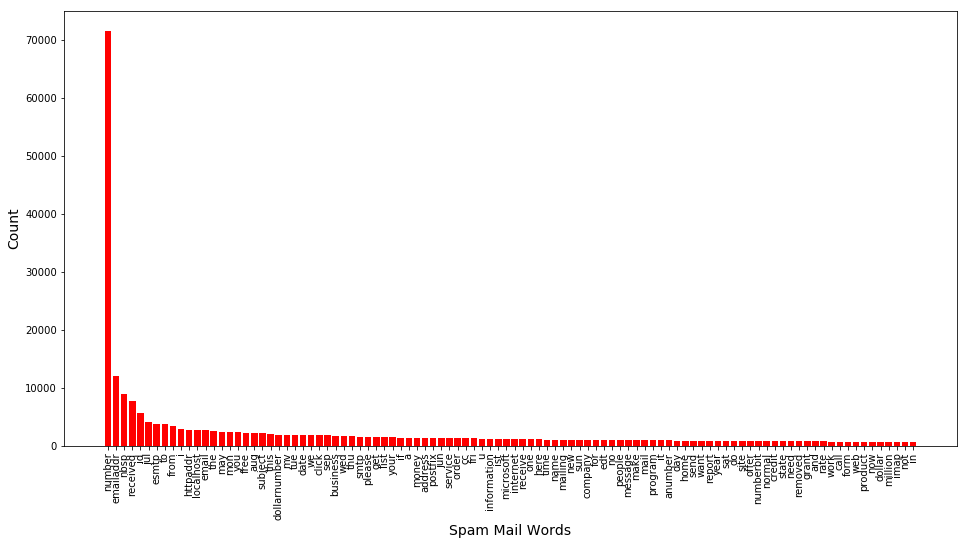

In [52]:
#Plot Top 100 SPAM word and its frequency
dataLength = len(sorted_allSpamWordFrequency) if len(sorted_allSpamWordFrequency)<100 else 100
spamWords, spamWordsFrequency = zip(*sorted_allSpamWordFrequency[0:dataLength])

x_pos = np.arange(dataLength) 

plt.figure(figsize=(16, 8))
plt.bar(x_pos, spamWordsFrequency,color='r')
plt.xticks(x_pos, spamWords, rotation='vertical') 
plt.xlabel("Spam Mail Words", fontsize=14)  
plt.ylabel("Count", fontsize=14)
plt.show()

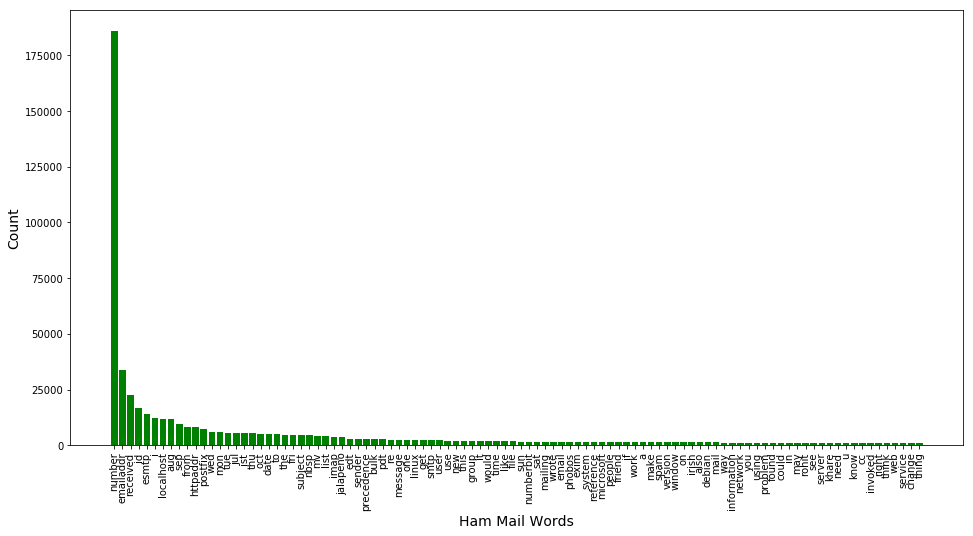

In [53]:
#Plot Top 100 HAM word and its frequency
dataLength = len(sorted_allHamWordFrequency) if len(sorted_allHamWordFrequency)<100 else 100
hamWords, hamWordsFrequency = zip(*sorted_allHamWordFrequency[0:dataLength])

x_pos = np.arange(dataLength) 

plt.figure(figsize=(16, 8))
plt.bar(x_pos, hamWordsFrequency,color='g')
plt.xticks(x_pos, hamWords, rotation='vertical') 
plt.xlabel("Ham Mail Words", fontsize=14)  
plt.ylabel("Count", fontsize=14)
plt.show()

# Data Processing

In this section, we will prepare the data for modeling, training and testing. We are also using sklearn.feature_extraction.text TfidfVectorizer to convert a collection of raw documents to a matrix of TF-IDF features.

In [10]:
emailtext = [ preprocess_normalize(email)for email in spamMailList]
y = [1 for email in spamMailList]

emailtext = emailtext + [ preprocess_normalize(email)for email in hamMailList]
y = y + [0 for email in hamMailList]

In [11]:
#Shuffle and split the dataset into the number of training and testing points
X_train,X_test,y_train,y_test = train_test_split(emailtext, y, test_size=0.2, random_state=3)

# Initialize the vectorizer
vectorizer = TfidfVectorizer(analyzer = 'word', use_idf=True ,tokenizer= LemmatizerTokenizer())

## Training and Evaluation
In this section we are training and testing different supervised learning models and evaluate there performance 

A helper function train_predict is implemented   for  training and testing different supervised learning models. 
The function takes as input a classifier, and the training and testing data. It creates a sklearn pipeline using the vectorizer created in data processing step. Using this pipeline, the model is trained.


#### Scorer Funcion:
In the given dataset, the spam ratio is 31% only. For such problem f1score is a better metric to analyse performance of a classifier since Classification accuracy not enough to measure accuracy of a classifier.


In [12]:
from sklearn.preprocessing import FunctionTransformer

def train_predict(clf, X_train, y_train, X_test, y_test):
    
    pipeline = make_pipeline(vectorizer, FunctionTransformer(lambda x: x.todense(), accept_sparse=True),  clf)
    
    print ("Training Classifier : {} on a training set size of {} . . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    start_Train = time()
    pipeline.fit(X_train, y_train)
    end_Train = time()
    
    # Predict from trained classifier on train set    
    y_pred_train = pipeline.predict(X_train)
    
    # Predict from trained classifier on test set
    start_Pred_test = time()
    y_pred_test = pipeline.predict(X_test)
    end_Pred_test = time()
    
    #calculate f1 score
    f1socre_train = f1_score(y_train, y_pred_train, pos_label=1)
    f1socre_test = f1_score(y_test, y_pred_test, pos_label=1)
    
    # Print the f1 score
    print ("Training Time: {:.3f} , Prediction Time : {:.3f} , f1 score (training) : {:.4f} , f1 score (testing) : {:.4f}".format(end_Train - start_Train, end_Pred_test -start_Pred_test , f1socre_train, f1socre_test))



Training DataSet is trimmed into different sizes to be used during model evaluation

In [13]:
#Set up the training set sizes
dataSize = len(X_train)
X_train_25 = X_train[:int(dataSize * .25)]
y_train_25 = y_train[:int(dataSize * .25)]

X_train_50 = X_train[:int(dataSize * .5)]
y_train_50 = y_train[:int(dataSize * .5)]

X_train_75 = X_train[:int(dataSize * .75)]
y_train_75 = y_train[:int(dataSize * .75)]


Training sklearn DummyClassifier to be used as baseline to compare with other classifiers. DummyClassifier makes predictions using simple rules

In [37]:
# train a DummyClassifier to be used as baseline
from sklearn.dummy import DummyClassifier

clf_baseline =  DummyClassifier()

train_predict(clf_baseline, X_train_25, y_train_25, X_test, y_test)
train_predict(clf_baseline, X_train_50, y_train_50, X_test, y_test)
train_predict(clf_baseline, X_train_75, y_train_75, X_test, y_test)
train_predict(clf_baseline, X_train, y_train, X_test, y_test)


Training Classifier : DummyClassifier on a training set size of 1107 . . .
Training Time: 9.316 , Prediction Time : 10.508 , f1 score (training) : 0.2888 , f1 score (testing) : 0.3127
Training Classifier : DummyClassifier on a training set size of 2214 . . .
Training Time: 18.956 , Prediction Time : 11.844 , f1 score (training) : 0.2980 , f1 score (testing) : 0.3014
Training Classifier : DummyClassifier on a training set size of 3321 . . .
Training Time: 28.462 , Prediction Time : 10.744 , f1 score (training) : 0.2981 , f1 score (testing) : 0.2917
Training Classifier : DummyClassifier on a training set size of 4429 . . .
Training Time: 39.874 , Prediction Time : 9.797 , f1 score (training) : 0.2996 , f1 score (testing) : 0.3150


In this section, you will choose 4 supervised learning models that are appropriate for this problem and available in scikit-learn. We will then fit the model to varying sizes of training data  and measure the F1 score.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

#Initialize the  models

clf_A = GaussianNB()
clf_B = LogisticRegression(random_state=3)
clf_C = KNeighborsClassifier()
clf_D = svm.LinearSVC(random_state=3)

# Execute the 'train_predict' function for each classifier and each training set size
train_predict(clf_A, X_train_25, y_train_25, X_test, y_test)
train_predict(clf_A, X_train_50, y_train_50, X_test, y_test)
train_predict(clf_A, X_train_75, y_train_75, X_test, y_test)
train_predict(clf_A, X_train, y_train, X_test, y_test)

train_predict(clf_B, X_train_25, y_train_25, X_test, y_test)
train_predict(clf_B, X_train_50, y_train_50, X_test, y_test)
train_predict(clf_B, X_train_75, y_train_75, X_test, y_test)
train_predict(clf_B, X_train, y_train, X_test, y_test)

train_predict(clf_C, X_train_25, y_train_25, X_test, y_test)
train_predict(clf_C, X_train_50, y_train_50, X_test, y_test)
train_predict(clf_C, X_train_75, y_train_75, X_test, y_test)
train_predict(clf_C, X_train, y_train, X_test, y_test)

train_predict(clf_D, X_train_25, y_train_25, X_test, y_test)
train_predict(clf_D, X_train_50, y_train_50, X_test, y_test)
train_predict(clf_D, X_train_75, y_train_75, X_test, y_test)
train_predict(clf_D, X_train, y_train, X_test, y_test)


Training Classifier : GaussianNB on a training set size of 1107 . . .
Training Time: 12.021 , Prediction Time : 10.775 , f1 score (training) : 0.9985 , f1 score (testing) : 0.7766
Training Classifier : GaussianNB on a training set size of 2214 . . .
Training Time: 19.214 , Prediction Time : 10.936 , f1 score (training) : 0.9992 , f1 score (testing) : 0.8402
Training Classifier : GaussianNB on a training set size of 3321 . . .
Training Time: 29.743 , Prediction Time : 11.136 , f1 score (training) : 0.9985 , f1 score (testing) : 0.8529
Training Classifier : GaussianNB on a training set size of 4429 . . .
Training Time: 40.910 , Prediction Time : 11.493 , f1 score (training) : 0.9989 , f1 score (testing) : 0.8677
Training Classifier : LogisticRegression on a training set size of 1107 . . .
Training Time: 9.893 , Prediction Time : 9.509 , f1 score (training) : 0.8940 , f1 score (testing) : 0.8306
Training Classifier : LogisticRegression on a training set size of 2214 . . .
Training Time: 1

#### Tabular Representation of Model's Performance

** Classifer 1 - GaussianNB **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 1107              |        12.021           |      10.775            |       0.9985     |     0.7766      |
| 2214              |        19.214           |      10.936            |       0.9992     |     0.8402      |
| 3321              |        29.743           |      11.136            |       0.9985     |     0.8529      |
| 4429              |        40.91            |      11.493            |       0.9989     |     0.8529      |

** Classifer 2 - LogisticRegression**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------:| :--------------: | :-------------: |
| 1107              |        9.893            |      9.509            |       0.894      |     0.8306      |
| 2214              |        18.691           |      10.193           |       0.9298     |     0.904       |
| 3321              |        28.036           |      10.767           |       0.9453     |     0.9219      |
| 4429              |        37.275           |      9.884            |       0.9573     |     0.9329      |

** Classifer 3 - KNeighborsClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------:| :--------------: | :-------------: |
| 1107              |        9.299            |      60.775           |       0.8486     |     0.7885      |
| 2214              |        20.927           |      166.08           |       0.8993     |     0.8311      |
| 3321              |        33.955           |      274.445          |       0.9123     |     0.8576      |
| 4429              |        48.149           |      493.512          |       0.9333     |     0.8826      |

** Classifer 4 - LinearSVC **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------:| :--------------: | :-------------: |
| 1107              |        11.533           |      9.919            |       0.997      |     0.9601      |
| 2214              |        18.27            |      9.88             |       0.9985     |     0.9721      |
| 3321              |        29.858           |      9.749            |       0.998      |     0.9736      |
| 4429              |        38.874           |      10.208           |       0.9985     |     0.9796      |


### Choosing the Best Model

In the above table gives we can see that KNN classification is very slow. Gaussian Naïve Bayes and Logistic Regression Classifier are having similar training time and prediction time, but Logistic Regression Classifiers has higher score. Overall Linear SVC model seems to be the best classifier, because the model is giving the highest testing F1 score among the other models. Training and prediction time is also comparable to Logistic Regression and Gaussian NB models in the experiment

## Model Tuning
Fine tune the chosen model. Use grid search (GridSearchCV) with at important parameters

Following are the steps implemented for Model Tuning 

•	Import sklearn.grid_search.GridSearchCV and sklearn.metrics.make_scorer.
•	Initialize the classifier chosen for fine tuning 
•	Create the parameters list to tune
•	Make an f1 scoring function using 'make_scorer’ and store it in f1_scorer
•	Initialize Pipeline using the vectorizer, FunctionTransformer and classifier
•	Perform grid search on the classifier using the pipeline, parameters and f1_scorer as the scoring method and store it in grid_obj
•	Fit the grid_object to the training data and find the optimal parameters,
•	Get the best estimator from the grid_object 
•	Report the final F1 score for training and testing using the best estimator


In [17]:
# Import 'GridSearchCV' and 'make_scorer'

from sklearn import grid_search
from sklearn.metrics import make_scorer

# filter DeprecationWarning for cross validation 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize the classifier
clf = svm.LinearSVC(random_state=3) 

# Create the parameters list to tune
parameters = {'linearsvc__C':[1, 10, 100], 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)]}

# Make an f1 scoring function using 'make_scorer' 
f1_scorer =  make_scorer(f1_score , pos_label= 1)

# Initialize Pipeline
pipeline = make_pipeline(vectorizer, FunctionTransformer(lambda x: x.todense(), accept_sparse=True),  clf)

# Perform grid search on the classifier using the pipeline, parameters and  f1_scorer as the scoring method
grid_obj = grid_search.GridSearchCV(pipeline, parameters, scoring=f1_scorer, cv=5)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_

print("Classifier Best Parameters : {} ".format( grid_obj.best_params_))

# Report the final F1 score for training and testing after parameter tuning
print ("Tuned model has a training F1 score of {:.4f}.".format(f1_score(y_train, clf.predict(X_train), pos_label=1)))
print ("Tuned model has a testing F1 score of {:.4f}.".format(f1_score(y_test, clf.predict(X_test), pos_label=1)))

Classifier Best Parameters : {'linearsvc__C': 10, 'tfidfvectorizer__ngram_range': (1, 1)} 
Tuned model has a training F1 score of 0.9993.
Tuned model has a testing F1 score of 0.9855.


### Sensivity Analysis of the final model
In this section we are validating the robustness of this model and its solution. We are manipulating the input data to see how the model’s solution is affected

In [18]:
print ("Tuned model F1 score on 25% of training data {:.4f}.".format(f1_score(y_train_25, clf.predict(X_train_25), pos_label=1)))
print ("Tuned model F1 score on 50% of training data {:.4f}.".format(f1_score(y_train_50, clf.predict(X_train_50), pos_label=1)))
print ("Tuned model F1 score on 75% of training data {:.4f}.".format(f1_score(y_train_75, clf.predict(X_train_75), pos_label=1)))
print ("Tuned model F1 score on entire data {:.4f}.".format(f1_score(y, clf.predict(emailtext), pos_label=1)))

Tuned model F1 score on 25% of training data 0.9985.
Tuned model F1 score on 50% of training data 0.9992.
Tuned model F1 score on 75% of training data 0.9990.
Tuned model F1 score on entire data 0.9964.


The above data  shows that the final classifier is robust and performance is not affected much by the changes in input data

### Classifier Reports

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
predicted = clf.predict(emailtext)

print("Confusion Matrix: ")
print(confusion_matrix(y, predicted))


Confusion Matrix: 
[[3841    4]
 [   8 1684]]


In [24]:
print("Classification Report: ")
print(classification_report(y, predicted,  target_names=['Ham','Spam']))

Classification Report: 
             precision    recall  f1-score   support

        Ham       1.00      1.00      1.00      3845
       Spam       1.00      1.00      1.00      1692

avg / total       1.00      1.00      1.00      5537



### Result
The result shows that the LinearSVC model has learnt significantly from the training data set and able to predict lot better on the test data set. Its F1 Score is much better than that of the baseline model. The fine-tuned Linear SVC model perform marginally better that the LinearSVC with default parameters. The fine-tuned classifier is giving training F1 score of 0.9993 and Testing score of 0.9855

By looking at the confusion matrix, it is evident that out of 3845 ham mails, model is able to successfully classify 3841 emails and out of 1692 ham mails, the model is able to classify 1684 emails. The false positive count is 4 and false negative is 8. Cases of false positive and false negative are quite low

## Appendix 

### TF-IDF Features Visualization
TF-IDF vectorization of a corpus of text documents assigns each word in a document a number that is proportional to its frequency in the document and inversely proportional to the number of documents in which it occurs. Very common words, thereby receive heavily discounted tf-idf scores, in contrast to words that are very specific to the document in question. Visualizing  such TF-IDF score for Spam and Ham mails below.  
The code to analyse tf-idf result is taken from  https://buhrmann.github.io/tfidf-analysis.html

In [34]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str( "Spam" if df.label==True else "Ham"), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

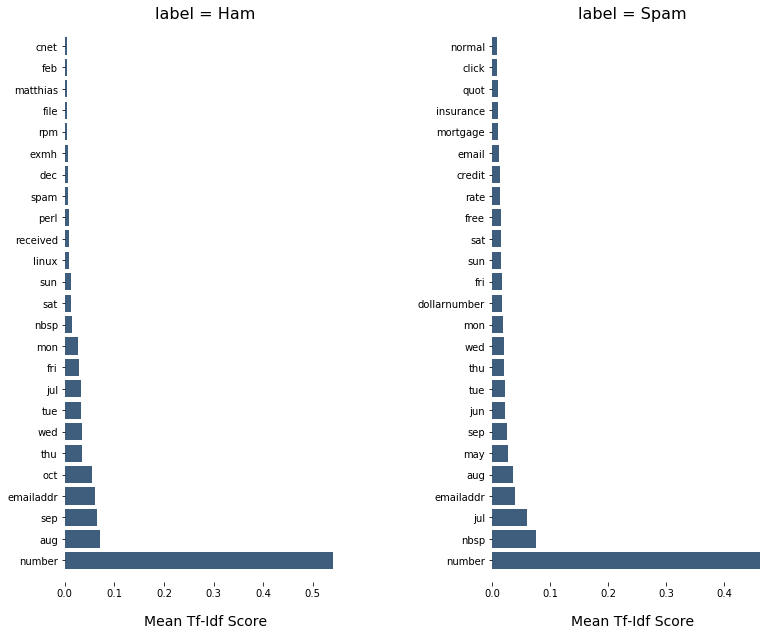

In [36]:
Xtr = vectorizer.fit_transform(emailtext)
features = vectorizer.get_feature_names()

dfs = top_feats_by_class(Xtr, y, features)
plot_tfidf_classfeats_h(dfs)